In [ ]:
!apt-get update
!apt-get install -y libreoffice
!pip install openai tiktoken langchain replicate kor python-docx unoconv

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,545 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,998 kB]
Get:13 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:14 https://ppa.lau

In [ ]:
import os
os.environ["REPLICATE_API_TOKEN"] = "r8_HqIqEA3jT4AAul736BmwnQ8Vh8pCEf72R19F6"
os.environ["OPENAI_API_KEY"] = "sk-proj-iZoJUKW0cR5Y4WUxiRyET3BlbkFJZ7gbGgTjFdpzI9rbAAvc"
os.environ["OPENAI_ORGANIZATION"] = "org-G2VIvHPcQf6sen9F7OFGbKnB"

In [ ]:
from tqdm import tqdm
from PIL import Image
import requests
from io import BytesIO
import cv2
from google.colab.patches import cv2_imshow

from docx import Document
from docx.shared import Inches, Pt
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT

import subprocess

from langchain import PromptTemplate, LLMChain
!pip install langchain_community
from langchain.llms import Replicate, OpenAI


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 8.0 MB/s eta 0:00:00


In [ ]:
template = """Write a short story about {topic}.
First generate a title for the story and a cover picture. Make the story in a narrative format.
Divide it into 5 chapters. Limit each chapter to 200 words. Also generate a prompt for an image generation model at the end of each chapter.
Always generate the output in following format:

Title: Main title of the story
Cover Image: Prompt for image generation model
Chapter 1:
Title: Title of chapter 1
Text: Story text of chapter 1
Image Prompt: Prompt for image generation model
Chapter 2:
Title: Title of chapter 2
Text: Story text of chapter 2
Image Prompt: Prompt for image generation model
Chapter n:
Title: Title of chapter n
Text: Story text of chapter n
Image Prompt: Prompt for image generation model



"""

prompt = PromptTemplate(template=(template), input_variables=["topic"])

In [ ]:
llm = OpenAI(temperature=0.7, model="text-davinci-003", max_tokens=2000)
llm_chain = LLMChain(prompt=prompt, llm=llm)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `OpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAI`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


In [ ]:
def animal_adventure():
    # Prompt the user for a topic
    topic_text = input("Enter an animal adventure topic (e.g., 'A day in the life of a squirrel'): ")

    # Predefined response based on the input
    response = f"Today's adventure is about: {topic_text}. Let's explore what happens in this story!"

    # Print the response
    print(response)

# Call the function to start the process
animal_adventure()


Enter an animal adventure topic (e.g., 'A day in the life of a squirrel'): An animal kingdom which used to live peacefully in the jungle and  one day humans start to capture their land. The animals plan to attack the  human base and gain control of the land again. But this ends up to be a  endless battle in the end the everyone - humans and animals dies.  End with a moral of the story.
Today's adventure is about: An animal kingdom which used to live peacefully in the jungle and  one day humans start to capture their land. The animals plan to attack the  human base and gain control of the land again. But this ends up to be a  endless battle in the end the everyone - humans and animals dies.  End with a moral of the story.. Let's explore what happens in this story!


In [ ]:
with open('animal_adventure.txt', 'r') as file:
    lines = file.readlines()

story = {}
is_chapter = False

chapters = []
chapter_dict = {}

for line in lines:



    line_sm = line.lower().strip()

    if 'title' in line_sm and not is_chapter:
        story['title'] = line.split(':')[-1].strip()

    if 'title' in line_sm and is_chapter:
        chapter_dict['title'] = line.split(':')[-1].strip()

    if 'cover image' in line_sm:
        story['cover_image'] = line.split(':')[-1].strip()

    if 'text' in line_sm:
        chapter_dict['text'] = line.split(':')[-1].strip()

    if 'image prompt' in line_sm:
        chapter_dict['image_prompt'] = line.split(':')[-1].strip()
        chapters.append(chapter_dict)

    if 'chapter' in line_sm:
        is_chapter = True
        chapter_dict = {}
        continue

story['chapters'] = chapters
story

{'chapters': []}

In [ ]:
text2image = Replicate(
    model="stability-ai/stable-diffusion:db21e45d3f7023abc2a46ee38a23973f6dce16bb082a930b0c49861f96d1e5bf",
    input={"image_dimensions": "512x512"},
)

In [ ]:
style_prompts = " Graphic Novel, 4K, Global Illumination, Dreamy"

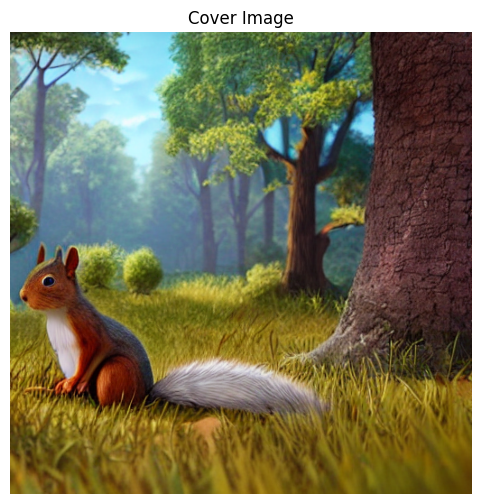

0it [00:00, ?it/s]

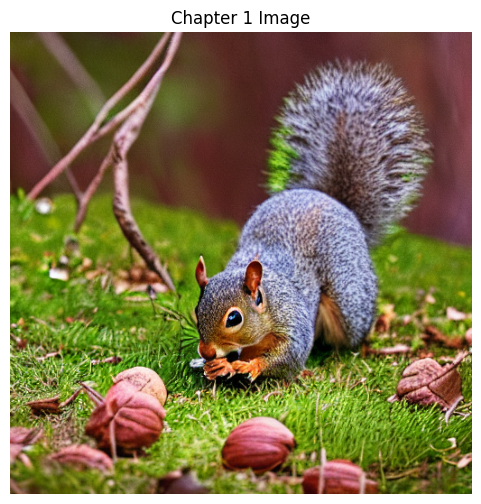

1it [00:02,  2.53s/it]

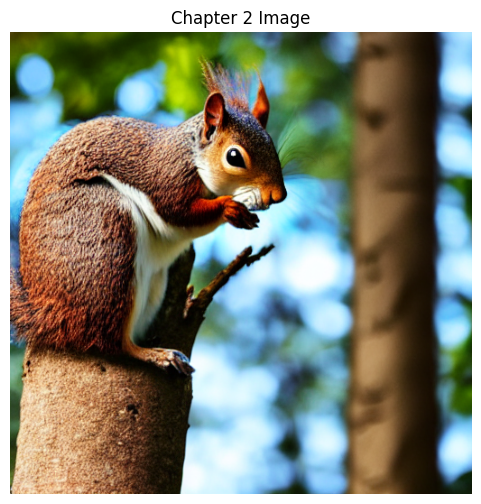

2it [00:05,  2.53s/it]

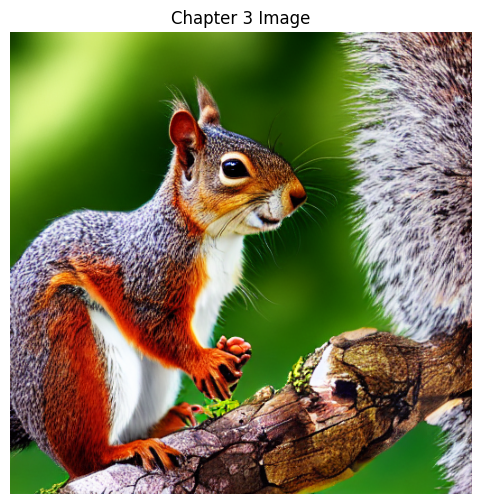

3it [00:08,  2.98s/it]

{'cover_image': './images/cover_image.jpg', 'chapter_images': ['./images/chapter_1.jpg', './images/chapter_2.jpg', './images/chapter_3.jpg']}


In [ ]:
# Example definitions for image_prompts_dict and style_prompts
image_prompts_dict = {
    "cover_image": "A beautiful fantasy landscape with a squirrel",
    "chapter_image_prompts": [
        "A squirrel foraging for nuts in a forest",
        "A squirrel climbing a tall tree",
        "A squirrel playing with other animals"
    ]
}

#style_prompts = "in a colorful and whimsical style"

# Your existing image generation code follows here
import os
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the image path
img_path = './images/'

# Create the images directory if it doesn't exist
if not os.path.exists(img_path):
    os.makedirs(img_path)

# Dictionary to store generated images paths
generated_images_dict = {}

# Get the cover image prompt
cover_image_prompt = image_prompts_dict["cover_image"]
cover_image_prompt += style_prompts  # Style of image

# Execute image generation pipeline
image_output = text2image(cover_image_prompt)

# Get the image response
response = requests.get(image_output)
image_output = Image.open(BytesIO(response.content))

# Save the cover image
cover_path = os.path.join(img_path, 'cover_image.jpg')
image_output.save(cover_path)
generated_images_dict["cover_image"] = cover_path

# Display the cover image
plt.figure(figsize=(6, 6))
plt.imshow(image_output)
plt.axis('off')  # Hide axes
plt.title("Cover Image")
plt.show()

# List to store chapter images
chapter_images = []
for idx, chapter_image_prompts in tqdm(enumerate(image_prompts_dict["chapter_image_prompts"])):
    chapter_image_prompts += style_prompts
    image_output = text2image(chapter_image_prompts)
    response = requests.get(image_output)
    image_output = Image.open(BytesIO(response.content))

    # Save each chapter image
    chapter_path = os.path.join(img_path, f'chapter_{idx+1}.jpg')
    image_output.save(chapter_path)
    chapter_images.append(chapter_path)

    # Display each chapter image
    plt.figure(figsize=(6, 6))
    plt.imshow(image_output)
    plt.axis('off')  # Hide axes
    plt.title(f"Chapter {idx + 1} Image")
    plt.show()

# Store chapter images in the dictionary
generated_images_dict["chapter_images"] = chapter_images

# Display the generated images dictionary
print(generated_images_dict)


In [ ]:
{'cover_image': './images/cover_image.jpg',
 'chapter_images': ['./images/chapter_1.jpg',
  './images/chapter_2.jpg',
  './images/chapter_3.jpg',
  './images/chapter_4.jpg',
  './images/chapter_5.jpg']}

{'cover_image': './images/cover_image.jpg',
 'chapter_images': ['./images/chapter_1.jpg',
  './images/chapter_2.jpg',
  './images/chapter_3.jpg',
  './images/chapter_4.jpg',
  './images/chapter_5.jpg']}

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the image prompts
image_prompts_dict = {
    "cover_image": "A beautiful fantasy landscape with a squirrel",
    "chapter_image_prompts": [
        "A squirrel foraging for nuts in a forest",
        "A squirrel climbing a tall tree in a colorful forest",
        "A squirrel playing with other animals in a vibrant meadow"
    ]
}

# Define the image path
img_path = './images/'

# Create the images directory if it doesn't exist
if not os.path.exists(img_path):
    os.makedirs(img_path)

# Dictionary to store generated images paths
generated_images_dict = {}

# Function to create a placeholder image
def create_placeholder_image(text, size=(256, 256)):
    # Create a blank image with a solid color
    image = Image.new('RGB', size, color=(255, 255, 255))
    # Add text to the image
    plt.text(size[0] // 2, size[1] // 2, text, ha='center', va='center', fontsize=12, color='black')
    plt.axis('off')
    plt.savefig('./temp_image.png', bbox_inches='tight', pad_inches=0)
    plt.close()
    return Image.open('./temp_image.png')

# Generate and save the cover image
cover_image = create_placeholder_image(image_prompts_dict["cover_image"])
cover_path = os.path.join(img_path, 'cover_image.jpg')
cover_image.save(cover_path)
generated_images_dict["cover_image"] = cover_path

# Display the cover image
plt.figure(figsize=(6, 6))
plt.imshow(cover_image)
plt.axis('off')
plt.title("Cover Image")
plt.show()

# List to store chapter images
chapter_images = []
for idx, chapter_image_prompt in tqdm(enumerate(image_prompts_dict["chapter_image_prompts"])):
    chapter_image = create_placeholder_image(chapter_image_prompt)
    chapter_path = os.path.join(img_path, f'chapter_{idx+1}.jpg')
    chapter_image.save(chapter_path)
    chapter_images.append(chapter_path)

    # Display each chapter image
    plt.figure(figsize=(6, 6))
    plt.imshow(chapter_image)
    plt.axis('off')
    plt.title(f"Chapter {idx + 1} Image")
    plt.show()

# Store chapter images in the dictionary
generated_images_dict["chapter_images"] = chapter_images

# Display the generated images dictionary
print(generated_images_dict)
